In [27]:
import yt_dlp
from collections import defaultdict
from sklearn.cluster import DBSCAN
from imutils import build_montages, paths
import numpy as np
import os
import pickle
import cv2
import shutil
import time
from tqdm import tqdm
import face_recognition
from PIL import Image
import re

In [63]:
def rescale_by_height(image, target_height, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_height` (preserving aspect ratio)."""
    w = int(round(target_height * image.shape[1] / image.shape[0]))
    return cv2.resize(image, (w, target_height), interpolation=method)

# Given a target width, adjust the image by calculating the height and resize
def rescale_by_width(image, target_width, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_width` (preserving aspect ratio)."""
    h = int(round(target_width * image.shape[0] / image.shape[1]))
    return cv2.resize(image, (target_width, h), interpolation=method)

def auto_resize(frame):
    height, width, _ = frame.shape

    if height > 500:
        frame = rescale_by_height(frame, 500)
        auto_resize(frame)
    
    if width > 700:
        frame = rescale_by_width(frame, 700)
        auto_resize(frame)
    
    return frame

class VideoProcessor:
    def __init__(self, url):
        self.video_id = self.get_videoid(url)
        
        self.video_dir = os.path.join("videos", self.video_id)
        os.makedirs(self.video_dir,exist_ok=True)
        
        self.video_path = os.path.join(self.video_dir, self.video_id + ".mp4")
        self.encodings_pkl_path = os.path.join(self.video_dir,"encodings.pickle")
        
        self.frames_dir = os.path.join(self.video_dir,"frames")
        os.makedirs(self.frames_dir,exist_ok=True)
        
        self.encodings_dir = os.path.join(self.video_dir, "encodings")
        os.makedirs(self.encodings_dir,exist_ok=True)
        
        self.download_video()

    def download_video(self):
        if os.path.exists(self.video_path):
            print("file exists")
            return
        ydl_opts = {
            "format": "bestvideo[height<=360][ext=mp4]+bestaudio[ext=m4a]/best[height<=360][ext=mp4]",
            "outtmpl": self.video_path,
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([f"https://youtube.com/watch?v={self.video_id}"])
            
    def get_videoid(self, url):
        re_match = re.match(
            "(?:https?:\/\/)?(?:www\.)?(?:youtube\.com\/(?:[^\/\n\s]+\/\S+\/|(?:v|e(?:mbed)?)\/|\S*?[?&]v=)|youtu\.be\/)([a-zA-Z0-9_-]{11})",
            url,
        )
        return re_match.group(1)
    
    def extract_frames(self, save_freq=60):            
        cap = cv2.VideoCapture(self.video_path)
        _, frame = cap.read()
    
        fps = cap.get(cv2.CAP_PROP_FPS)
        TotalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    
        print("[INFO] Total Frames ", TotalFrames, " @ ", fps, " fps")
        print("[INFO] Calculating number of frames per second")
    
        if os.path.exists(self.frames_dir):
            shutil.rmtree(self.frames_dir)
            time.sleep(0.5)
        os.mkdir(self.frames_dir)
    
        frame_count = 1
        while frame_count < TotalFrames:
            success, frame = cap.read()
            if not success:
                break
            if frame_count % int(fps) == 0:
                print('got frame',frame_count)
                frame = auto_resize(frame)
                filename = "frame_" + str(frame_count) + ".jpg"
                cv2.imwrite(os.path.join(self.frames_dir, filename), frame)
            frame_count += 1
    
        print('[INFO] Frames extracted')

    def extract_encodings(self):
        print("Extract Encodings")
        data = []
        for id, image_path in enumerate(paths.list_images(self.frames_dir)):
            image = cv2.imread(image_path)
            rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            boxes = face_recognition.face_locations(rgb, model='cnn')
            encodings = face_recognition.face_encodings(rgb, boxes)
            d = [{"image_path": image_path, "loc": box, "encoding": enc} 
                    for (box, enc) in zip(boxes, encodings)]
    
            data.append({'id': id, 'encodings': d})
            print('extract', id)
        self.encodings_to_pkl(data)
        self.generate_main_encodings_pkl()
        print("DONE")

    def encodings_to_pkl(self, data):
        for d in data:
            encodings = d['encodings']
            id = d['id']
            with open(os.path.join(self.encodings_dir, 
                                'encodings_' + str(id) + '.pickle'), 'wb') as f:
                f.write(pickle.dumps(encodings))

    def generate_main_encodings_pkl(self):
        datastore = []
        pickle_paths = []
        
        for path in os.listdir(self.encodings_dir):
            if path.endswith('.pickle'):
                pickle_paths.append(os.path.join(self.encodings_dir, path))
    
        for pickle_path in pickle_paths:
            with open(pickle_path, "rb") as f:
                data = pickle.loads(f.read())
                datastore.extend(data)
    
        with open(self.encodings_pkl_path, 'wb') as f:
            f.write(pickle.dumps(datastore))
            print('wrote main pickle', self.encodings_pkl_path)

    def crop_image(self, loc, image):
        (o_top, o_right, o_bottom, o_left) = loc
        height, width, channel = image.shape
                
        widthMargin = 10
        heightMargin = 20
        
        top = o_top - heightMargin
        if top < 0:
            top = 0
        
        bottom = o_bottom + heightMargin
        if bottom > height:
            bottom = height
        
        left = o_left - widthMargin
        if left < 0:
            left = 0
        
        right = o_right + widthMargin
        if right > width:
            right = width
        
        image = image[top:bottom, left:right]
        image = rescale_by_width(image, 100)
        return image
    
    def cluster_images(self):        
        # load the serialized face encodings + bounding box locations from
        # disk, then extract the set of encodings to so we can cluster on
        # them
        print("[INFO] Loading encodings")
        data = pickle.loads(open(self.encodings_pkl_path, "rb").read())
        data = np.array(data)
        
        encodings = [d["encoding"] for d in data]
        
        # cluster the embeddings
        print("[INFO] Clustering")
        clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=1)
        clt.fit(encodings)
        print("DONE")
        
        # determine the total number of unique faces found in the dataset
        labels = clt.labels_
        label_ids = np.unique(labels)
        unique_faces_count = len(np.where(label_ids > -1)[0])
        print("[INFO] # unique faces: {}".format(unique_faces_count))

        result = defaultdict(lambda:[])
        for label in range(unique_faces_count):
            ids = np.where(labels == label)[0]
            print("Person", label, "photos", len(ids))
            for id in ids[:10]:
                image = cv2.imread(data[id]["image_path"])
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = self.crop_image(data[id]["loc"],image)
                result[label].append(image)
        return result

file exists
[INFO] Loading encodings
[INFO] Clustering
DONE
[INFO] # unique faces: 3
Person 0 photos 18
Person 1 photos 13
Person 2 photos 17


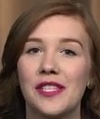

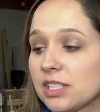

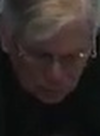

In [73]:
vp = VideoProcessor("https://www.youtube.com/watch?v=LOjjjvuMvQA")
# vp.extract_frames()
# vp.extract_encodings()
data = vp.cluster_images()
for face_id in data.keys():
    display(Image.fromarray(data[face_id][0]))

In [57]:
data[0]

TypeError: 'NoneType' object is not subscriptable

# Working

In [5]:
from collections import defaultdict
from sklearn.cluster import DBSCAN
from imutils import build_montages, paths
import numpy as np
import os
import pickle
import cv2
import shutil
import time
import dlib
from pyPiper import Node, Pipeline
from tqdm import tqdm
import face_recognition
from PIL import Image

def rescale_by_height(self, image, target_height, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_height` (preserving aspect ratio)."""
    w = int(round(target_height * image.shape[1] / image.shape[0]))
    return cv2.resize(image, (w, target_height), interpolation=method)

# Given a target width, adjust the image by calculating the height and resize
def rescale_by_width(self, image, target_width, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_width` (preserving aspect ratio)."""
    h = int(round(target_width * image.shape[0] / image.shape[1]))
    return cv2.resize(image, (target_width, h), interpolation=method)

def auto_resize(frame):

    height, width, _ = frame.shape

    if height > 500:
        frame = rescale_by_height(frame, 500)
        auto_resize(frame)
    
    if width > 700:
        frame = rescale_by_width(frame, 700)
        auto_resize(frame)
    
    return frame
    
def extract_encodings(images_dir):
    print("Extract Encodings")
    res = []
    for id, image_path in enumerate(paths.list_images(images_dir)):
        image = cv2.imread(image_path)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = face_recognition.face_locations(rgb, model='cnn')
        encodings = face_recognition.face_encodings(rgb, boxes)
        d = [{"image_path": image_path, "loc": box, "encoding": enc} 
                for (box, enc) in zip(boxes, encodings)]

        res.append({'id': id, 'encodings': d})
        print('extract', id)
    print("DONE")
    return res

def generate_frames(video_path, frames_dir):
    cap = cv2.VideoCapture(video_path)
    _, frame = cap.read()

    fps = cap.get(cv2.CAP_PROP_FPS)
    TotalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    print("[INFO] Total Frames ", TotalFrames, " @ ", fps, " fps")
    print("[INFO] Calculating number of frames per second")

    if os.path.exists(frames_dir):
        shutil.rmtree(frames_dir)
        time.sleep(0.5)
    os.mkdir(frames_dir)

    CurrentFrame = 1
    fpsCounter = 0
    FrameWrittenCount = 1
    while CurrentFrame < TotalFrames:
        success, frame = cap.read()
        if not success:
            break
        
        if fpsCounter > fps:
            fpsCounter = 0

            frame = auto_resize(frame)

            filename = "frame_" + str(FrameWrittenCount) + ".jpg"
            cv2.imwrite(os.path.join(frames_dir, filename), frame)

            FrameWrittenCount += 1
        if CurrentFrame % 50 == 0:
            print('got frame',CurrentFrame)
        fpsCounter += 1
        CurrentFrame += 1

    print('[INFO] Frames extracted')

def encodings_to_pkl(data,encodings_dir):
    os.makedirs(encodings_dir, exist_ok=True)
    for d in data:
        encodings = d['encodings']
        id = d['id']
        with open(os.path.join(encodings_dir, 
                            'encodings_' + str(id) + '.pickle'), 'wb') as f:
            f.write(pickle.dumps(encodings))

def generate_pkl(encodings_dir, pickle_path):
    datastore = []

    pickle_paths = []
    for item in os.listdir(encodings_dir):
        _, fileExt = os.path.splitext(item)
        if fileExt == '.pickle':
            pickle_paths.append(os.path.join(encodings_dir, item))

    for picklePath in pickle_paths:
        with open(picklePath, "rb") as f:
            data = pickle.loads(f.read())
            datastore.extend(data)

    with open(pickle_path, 'wb') as f:
        f.write(pickle.dumps(datastore))

In [6]:
video_path = "video.mp4"
frames_dir = "frames"
encodings_dir = "encodings"
generate_frames(video_path, frames_dir)
encoding_file_path = "encodings.pickle"
encodings = extract_encodings(frames_dir)
encodings_to_pkl(encodings,encodings_dir)
generate_pkl(encodings_dir,encoding_file_path)

[INFO] Total Frames  1861.0  @  29.97002997002997  fps
[INFO] Calculating number of frames per second
got frame 50
got frame 100
got frame 150
got frame 200
got frame 250
got frame 300
got frame 350
got frame 400
got frame 450
got frame 500
got frame 550
got frame 600
got frame 650
got frame 700
got frame 750
got frame 800
got frame 850
got frame 900
got frame 950
got frame 1000
got frame 1050
got frame 1100
got frame 1150
got frame 1200
got frame 1250
got frame 1300
got frame 1350
got frame 1400
got frame 1450
got frame 1500
got frame 1550
got frame 1600
got frame 1650
got frame 1700
got frame 1750
got frame 1800
got frame 1850
[INFO] Frames extracted
Extract Encodings
extract 0
extract 1
extract 2
extract 3
extract 4
extract 5
extract 6
extract 7
extract 8
extract 9
extract 10
extract 11
extract 12
extract 13
extract 14
extract 15
extract 16
extract 17
extract 18
extract 19
extract 20
extract 21
extract 22
extract 23
extract 24
extract 25
extract 26
extract 27
extract 28
extract 29
e

[INFO] # unique faces: 6
Label 0


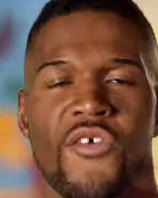

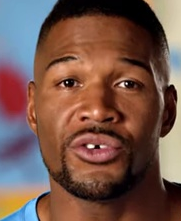

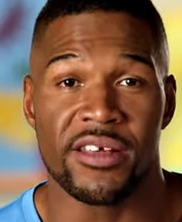

Label 2


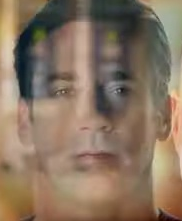

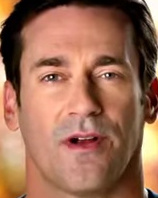

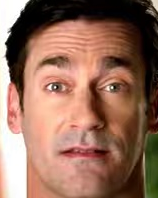

Label 1


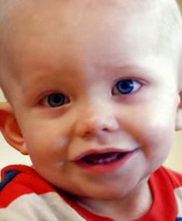

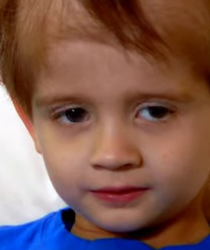

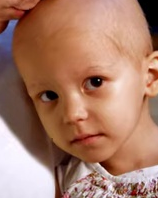

Label 3


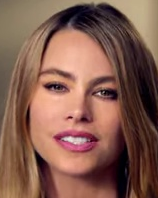

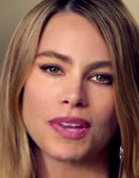

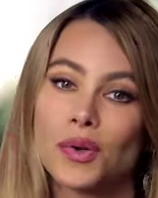

Label 4


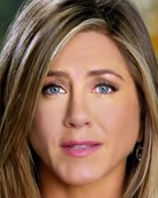

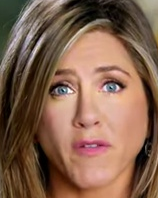

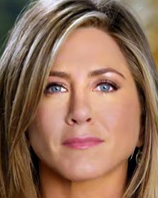

Label 5


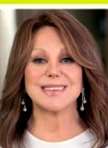

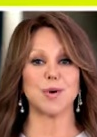

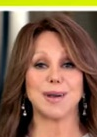

In [7]:
data = pickle.loads(open(encoding_file_path, "rb").read())
encodings = [d["encoding"] for d in data]
clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=-1)
clt.fit(encodings)

# determine the total number of unique faces found in the dataset
label_ids = np.unique(clt.labels_)
unique_face_count = len(np.where(label_ids > -1)[0])
print("[INFO] # unique faces: {}".format(unique_face_count))


# build up face dict
faces = defaultdict(lambda:[])
for label, val in zip(clt.labels_, data):
    if label < 0: continue
    faces[label].append({
        "image_path":val['image_path'],
        "loc":val["loc"]
    })

# list faces
for label in faces.keys():
    print("Label", label)
    for val in faces[label][:3]:
        image = cv2.imread(val['image_path'])
        padding = 20

        height, width, channel = image.shape
        
        o_top, o_right, o_bottom, o_left = val['loc']
        
        widthMargin = 20
        heightMargin = 40
        
        top = o_top - heightMargin
        if top < 0:
            top = 0
        bottom = o_bottom + heightMargin
        if bottom > height:
            bottom = height
        left = o_left - widthMargin
        if left < 0:
            left = 0
        right = o_right + widthMargin
        if right > width:
            right = width

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cropped_face = image[top:bottom, left:right]
        
        display(Image.fromarray(cropped_face))


# Face Recognition

In [3]:
from imutils import paths, build_montages
import face_recognition
import argparse
import pickle
import cv2
import os
from sklearn.cluster import DBSCAN
import numpy as np
import pickle
import time
import shutil

## Extract Frames

In [53]:
video_path = "video.mp4"
frames_dir = "frames"
encodings_dir = "encodings"
encodings_path = "encodings.pickle"

def mkdir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
mkdir(frames_dir)
mkdir(encodings_dir)

cap = cv2.VideoCapture(video_path)
_, frame = cap.read()

fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)


current_frame = 1
fps_counter = 0
frame_write_count = 1
while current_frame < total_frames:
    success, frame = cap.read()
    if not success:
        break
    
    if fps_counter > fps:
        fps_counter = 0

        frame = auto_resize(frame)

        filename = "frame_" + str(frame_write_count) + ".jpg"
        cv2.imwrite(os.path.join(frames_dir, filename), frame)

        frame_write_count += 1
    if current_frame % 50 == 0:
        print('got frame',current_frame)
    fps_counter += 1
    current_frame += 1

got frame 50
got frame 100
got frame 150
got frame 200
got frame 250
got frame 300
got frame 350
got frame 400
got frame 450
got frame 500
got frame 550
got frame 600
got frame 650
got frame 700
got frame 750
got frame 800
got frame 850
got frame 900
got frame 950
got frame 1000
got frame 1050
got frame 1100
got frame 1150
got frame 1200
got frame 1250
got frame 1300
got frame 1350
got frame 1400
got frame 1450
got frame 1500
got frame 1550
got frame 1600
got frame 1650
got frame 1700
got frame 1750
got frame 1800
got frame 1850


## Extract Encodings
something here is going wrong!

In [104]:
for i, img_path in enumerate(paths.list_images(frames_dir)):
    image = cv2.imread(img_path)
    print(img_path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = face_recognition.face_locations(rgb, model="cnn")
    fr_encodings = face_recognition.face_encodings(rgb, boxes)
    print(len(boxes),len(fr_encodings))
    d = [{"imagePath": img_path, "loc": box, "encoding": enc} 
            for (box, enc) in zip(boxes, fr_encodings)]
    # Save pkl
    with open(os.path.join(encodings_dir, 
                        'encodings_' + str(i) + '.pickle'), 'wb') as f:
        f.write(pickle.dumps(d))

frames/frame_35.jpg
1 1
frames/frame_55.jpg
1 1
frames/frame_15.jpg
1 1
frames/frame_16.jpg
1 1
frames/frame_7.jpg
1 1
frames/frame_53.jpg
1 1
frames/frame_32.jpg
1 1
frames/frame_10.jpg
1 1
frames/frame_45.jpg
1 1
frames/frame_36.jpg
1 1
frames/frame_18.jpg
2 2
frames/frame_47.jpg
1 1
frames/frame_21.jpg
1 1
frames/frame_60.jpg
0 0
frames/frame_43.jpg
2 2
frames/frame_40.jpg
1 1
frames/frame_46.jpg
1 1
frames/frame_38.jpg
1 1
frames/frame_61.jpg
0 0
frames/frame_39.jpg
1 1
frames/frame_19.jpg
1 1
frames/frame_20.jpg
1 1
frames/frame_13.jpg
1 1
frames/frame_41.jpg
1 1
frames/frame_8.jpg
1 1
frames/frame_25.jpg
2 2
frames/frame_6.jpg
1 1
frames/frame_56.jpg
1 1
frames/frame_51.jpg
1 1
frames/frame_9.jpg
1 1
frames/frame_14.jpg
1 1
frames/frame_59.jpg
0 0
frames/frame_12.jpg
1 1
frames/frame_54.jpg
1 1
frames/frame_11.jpg
2 2
frames/frame_22.jpg
1 1
frames/frame_33.jpg
1 1
frames/frame_48.jpg
1 1
frames/frame_28.jpg
1 1
frames/frame_30.jpg
1 1
frames/frame_3.jpg
1 1
frames/frame_50.jpg
1

## Generate Big Pickle

In [124]:
encodings_dir = "/home/lucaspy/FaceRecognitionPipeline_GeeksForGeeks/Encodings"
encodings_dir = "encodings"

datastore = []
pickle_paths = []
for item in os.listdir(encodings_dir):
    _, fileExt = os.path.splitext(item)
    if fileExt == '.pickle':
        pickle_paths.append(os.path.join(encodings_dir, item))

for picklePath in pickle_paths:
    with open(picklePath, "rb") as f:
        data = pickle.loads(f.read())
        datastore.extend(data)

print(datastore[1]['loc'],datastore[0]['imagePath'])
with open(encodings_path, 'wb') as f:
    f.write(pickle.dumps(datastore))

# (74, 439, 215, 297) frames/frame_36.jpg

(55, 473, 259, 269) frames/frame_36.jpg


In [98]:
# load the data
encodings_path = "/home/lucaspy/yoloface/encodings.pickle"
data = pickle.loads(open(encodings_path, "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=-1)
clt.fit(encodings)
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] # unique faces: 6


In [34]:
# gen images
data = pickle.loads(open(encodings_path, "rb").read())
data = np.array(data)
for labelID in labelIDs:
    print("[INFO] faces for face ID: {}".format(labelID))
    image_path_ids = np.where(clt.labels_ == labelID)[0]
    for i in image_path_ids:
        display(Image.open(imagePaths[i]))
        

[INFO] faces for face ID: -1


NameError: name 'imagePaths' is not defined

# Face Extract Test

In [27]:
def resize_image(image, new_width):
    original_width, original_height = image.size
    aspect_ratio = original_height / original_width
    new_height = int(new_width * aspect_ratio)
    return image.resize((new_width,new_height))

cpu
/home/lucaspy/yoloface/weights/yolov5n_state_dict.pt
(3800, 1359)


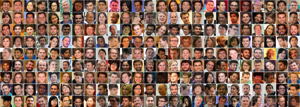

Extract Faces
227 Faces


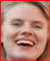

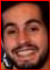

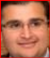

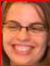

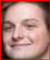

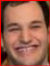

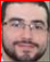

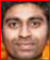

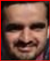

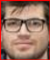

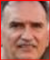

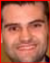

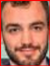

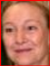

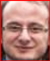

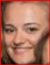

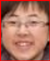

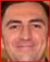

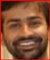

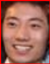

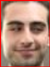

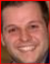

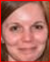

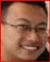

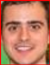

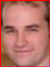

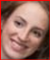

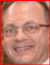

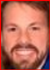

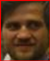

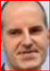

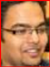

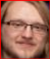

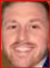

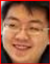

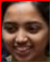

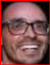

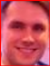

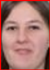

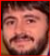

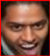

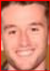

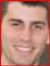

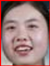

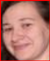

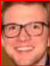

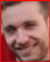

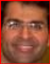

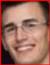

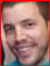

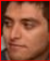

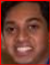

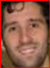

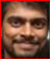

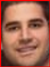

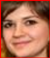

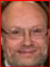

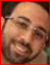

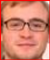

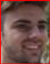

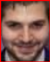

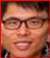

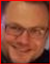

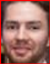

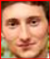

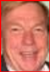

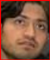

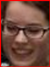

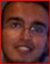

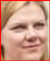

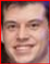

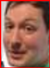

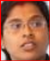

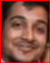

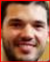

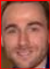

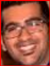

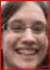

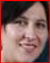

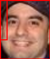

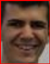

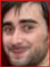

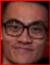

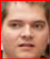

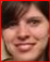

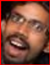

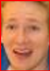

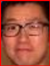

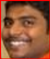

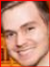

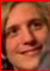

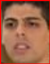

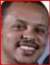

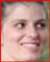

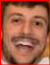

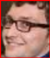

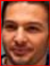

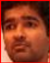

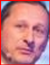

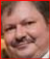

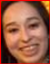

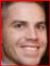

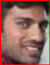

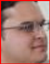

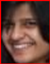

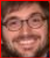

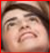

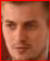

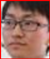

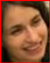

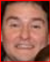

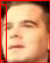

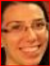

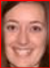

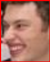

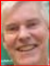

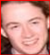

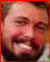

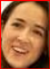

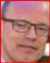

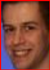

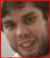

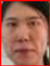

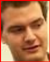

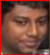

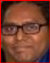

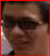

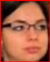

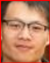

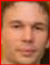

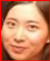

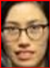

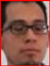

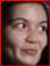

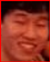

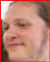

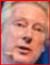

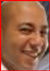

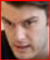

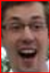

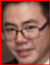

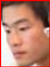

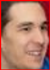

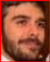

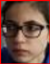

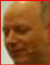

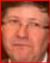

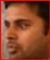

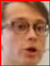

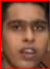

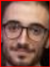

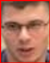

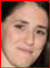

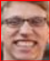

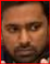

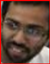

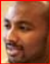

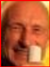

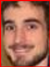

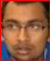

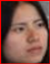

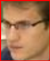

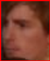

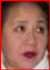

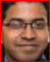

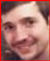

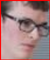

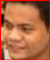

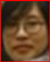

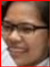

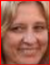

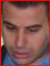

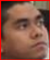

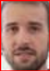

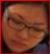

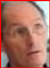

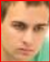

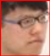

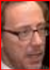

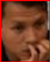

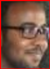

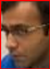

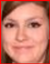

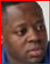

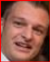

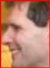

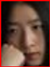

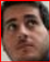

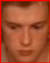

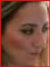

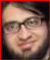

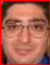

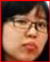

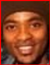

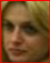

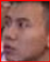

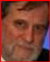

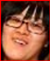

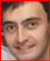

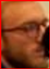

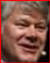

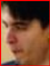

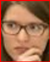

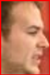

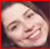

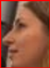

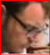

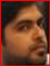

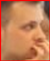

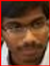

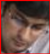

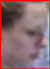

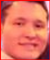

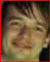

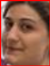

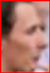

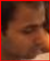

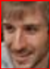

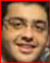

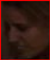

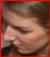

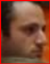

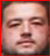

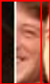

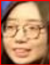

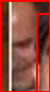

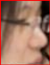

NameError: name 'os' is not defined

In [3]:
model = YoloDetector(target_size=800, device="cpu", min_face=90)

img = Image.open("many_faces.jpg")
img = resize_image(img, 3800)
print(img.size)
display(resize_image(img, 300))

# predict
bboxes, points = model.predict(np.array(img))

# Place bounding boxes
draw = ImageDraw.Draw(img)
for box in bboxes[0]:
    draw.rectangle(box, outline='red', width=2)

# Extract faces
print("Extract Faces")
faces = []
for box in bboxes[0]:
    face = resize_image(img.crop(box),50)
    faces.append(face)
    
print(len(faces),"Faces")
for face in faces:
    display(face)

for i in range(len(faces)):
    faces[i].save(os.path.join("yt",f"{i}.jpg"))